In [59]:
import math
import numpy as np
import scipy
from sklearn.utils.extmath import svd_flip, randomized_svd
from scipy.sparse.linalg import svds
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.metrics.pairwise import euclidean_distances
from tqdm import trange
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from data import HankelDataset
import sys
import scipy.io as sio

In [3]:
def median_heuristic(X, beta=0.5):
    max_n = min(30000, X.shape[0])
    D2 = euclidean_distances(X[:max_n], squared=True)
    med_sqdist = np.median(D2[np.triu_indices_from(D2, k=1)])
    beta_list = [beta**2, beta**1, 1, (1.0/beta)**1, (1.0/beta)**2]
    return [med_sqdist * b for b in beta_list]

In [4]:
def svd_wrapper(Y, k, method='svds'):
    if method == 'svds':
        Ut, St, Vt = svds(Y, k)
        idx = np.argsort(St)[::-1]
        St = St[idx] # have issue with sorting zero singular values
        Ut, Vt = svd_flip(Ut[:, idx], Vt[idx])
    elif method == 'random':
        Ut, St, Vt = randomized_svd(Y, k, random_state=0)
    else:
        Ut, St, Vt = np.linalg.svd(Y, full_matrices=False)
        # now truncate it to k
        Ut = Ut[:, :k]
        St = np.diag(St[:k])
        Vt = Vt[:k, :]
        
    return Ut, St, Vt

In [5]:
class NetG(nn.Module):
    def __init__(self, var_dim, RNN_hid_dim, num_layers:int=1):
        super().__init__()
        self.var_dim = var_dim
        self.RNN_hid_dim = RNN_hid_dim

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=num_layers, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=num_layers, batch_first=True)
        self.fc_layer = nn.Linear(self.RNN_hid_dim, self.var_dim)

    # X_p:   batch_size x wnd_dim x var_dim (Encoder input)
    # X_f:   batch_size x wnd_dim x var_dim (Decoder input)
    # h_t:   1 x batch_size x RNN_hid_dim
    # noise: 1 x batch_size x RNN_hid_dim
    def forward(self, X_p, X_f, noise):
        X_p_enc, h_t = self.rnn_enc_layer(X_p)
        X_f_shft = self.shft_right_one(X_f)
        hidden = h_t + noise
        Y_f, _ = self.rnn_dec_layer(X_f_shft, hidden)
        output = self.fc_layer(Y_f)
        return output

    def shft_right_one(self, X):
        X_shft = X.clone()
        X_shft[:, 0, :].data.fill_(0)
        X_shft[:, 1:, :] = X[:, :-1, :]
        return X_shft


class NetD(nn.Module):
    def __init__(self, var_dim, RNN_hid_dim, num_layers:int=1):
        super(NetD, self).__init__()

        self.var_dim = var_dim
        self.RNN_hid_dim = RNN_hid_dim

        self.rnn_enc_layer = nn.GRU(self.var_dim, self.RNN_hid_dim, num_layers=num_layers, batch_first=True)
        self.rnn_dec_layer = nn.GRU(self.RNN_hid_dim, self.var_dim, num_layers=num_layers, batch_first=True)

    def forward(self, X):
        X_enc, _ = self.rnn_enc_layer(X)
        X_dec, _ = self.rnn_dec_layer(X_enc)
        return X_enc, X_dec


In [26]:

class KL_CPD(nn.Module):
    def __init__(self, D:int, critic_iters:int=5,
            lambda_ae:float=0.001, lambda_real:float=0.1,
            p_wnd_dim:int=25, f_wnd_dim:int=10, sub_dim:int=1, RNN_hid_dim:int=10):
        super().__init__()
        self.p_wnd_dim = p_wnd_dim
        self.f_wnd_dim = f_wnd_dim
        self.sub_dim = sub_dim
        self.D = D
        self.var_dim = D * sub_dim
        self.critic_iters = critic_iters
        self.lambda_ae, self.lambda_real = lambda_ae, lambda_real
        self.RNN_hid_dim = RNN_hid_dim
        self.netD = NetD(self.var_dim, RNN_hid_dim)
        self.netG = NetG(self.var_dim, RNN_hid_dim)


    @property
    def device(self):
        return next(self.parameters()).device

    def __mmd2_loss(self, X_p_enc, X_f_enc):
        sigma_var = self.sigma_var

        # some constants
        n_basis = 1024
        gumbel_lmd = 1e+6
        cnst = math.sqrt(1. / n_basis)
        n_mixtures = sigma_var.size(0)
        n_samples = n_basis * n_mixtures
        batch_size, seq_len, nz = X_p_enc.size()

        # gumbel trick to get masking matrix to uniformly sample sigma
        # input: (batch_size*n_samples, nz)
        # output: (batch_size, n_samples, nz)
        def sample_gmm(W, batch_size):
            U = torch.FloatTensor(batch_size*n_samples, n_mixtures).uniform_().to(self.device)
            sigma_samples = F.softmax(U * gumbel_lmd, dim=1).matmul(sigma_var)
            W_gmm = W.mul(1. / sigma_samples.unsqueeze(1))
            W_gmm = W_gmm.view(batch_size, n_samples, nz)
            return W_gmm

        W = Variable(torch.FloatTensor(batch_size*n_samples, nz).normal_(0, 1).to(self.device))
        W_gmm = sample_gmm(W, batch_size)                                   # batch_size x n_samples x nz
        W_gmm = torch.transpose(W_gmm, 1, 2).contiguous()                   # batch_size x nz x n_samples
        XW_p = torch.bmm(X_p_enc, W_gmm)                                    # batch_size x seq_len x n_samples
        XW_f = torch.bmm(X_f_enc, W_gmm)                                    # batch_size x seq_len x n_samples
        z_XW_p = cnst * torch.cat((torch.cos(XW_p), torch.sin(XW_p)), 2)
        z_XW_f = cnst * torch.cat((torch.cos(XW_f), torch.sin(XW_f)), 2)
        batch_mmd2_rff = torch.sum((z_XW_p.mean(1) - z_XW_f.mean(1))**2, 1)
        return batch_mmd2_rff

    def forward(self, X_p:torch.Tensor, X_f:torch.Tensor):
        batch_size = X_p.size(0)

        X_p_enc, _ = self.netD(X_p)
        X_f_enc, _ = self.netD(X_f)
        Y_pred_batch = self.__mmd2_loss(X_p_enc, X_f_enc)

        return Y_pred_batch

    def predict(self, ts):
        dataset = HankelDataset(ts, self.p_wnd_dim, self.f_wnd_dim, self.sub_dim)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=False)
        preds = []
        with torch.no_grad():
            for batch in dataloader:
                X_p, X_f = [batch[key].float().to(self.device) for key in ['X_p', 'X_f']]
                pred_val = self.forward(X_p, X_f).cpu().detach().numpy()
                preds.append(pred_val)
        return np.concatenate(preds)



    def fit(self, ts, epoches:int=100,lr:float=3e-4,weight_clip:float=.1,weight_decay:float=0.,momentum:float=0.):
        # must be defined in fit() method
        optG = torch.optim.AdamW(self.netG.parameters(),lr=lr,weight_decay=weight_decay)

        optD = torch.optim.AdamW(self.netD.parameters(),lr=lr,weight_decay=weight_decay)


        dataset = HankelDataset(ts, self.p_wnd_dim, self.f_wnd_dim, self.sub_dim)
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
        sigma_list = median_heuristic(dataset.Y_hankel, beta=.5)
        self.sigma_var = torch.FloatTensor(sigma_list).to(self.device)

        tbar = trange(epoches)
        for epoch in tbar:
            for batch in dataloader:
                # Fit critic
                for p in self.netD.parameters():
                    p.requires_grad = True
                for p in self.netD.rnn_enc_layer.parameters():
                    p.data.clamp_(-weight_clip, weight_clip)
                (D_mmd2_mean, mmd2_real_mean, real_L2_loss, fake_L2_loss) = self._optimizeD(batch, optD)
                G_mmd2_mean = 0
                if np.random.choice(np.arange(self.critic_iters)) == 0:
                    # Fit generator
                    for p in self.netD.parameters():
                        p.requires_grad = False  # to avoid computation
                    G_mmd2_mean = self._optimizeG(batch, optG)
                
#             print('[%5d/%5d] D_mmd2 %.4e G_mmd2 %.4e mmd2_real %.4e real_L2 %.6f fake_L2 %.6f'
#               % (epoch+1, epoches, D_mmd2_mean, G_mmd2_mean, mmd2_real_mean, real_L2_loss, fake_L2_loss))


    def _optimizeG(self, batch, opt, grad_clip:int=10):
        X_p, X_f = [batch[key].float().to(self.device) for key in ['X_p', 'X_f']]
        batch_size = X_p.size(0)

        # real data
        X_f_enc, X_f_dec = self.netD(X_f)

        # fake data
        noise = torch.FloatTensor(1, batch_size, self.RNN_hid_dim).normal_(0, 1).to(self.device)
        noise = Variable(noise)
        Y_f = self.netG(X_p, X_f, noise)
        Y_f_enc, Y_f_dec = self.netD(Y_f)

        # batchwise MMD2 loss between X_f and Y_f
        G_mmd2 = self.__mmd2_loss(X_f_enc, Y_f_enc)

        # update netG
        self.netG.zero_grad()
        lossG = G_mmd2.mean()
        #lossG = 0.0 * G_mmd2.mean()
        lossG.backward()

        torch.nn.utils.clip_grad_norm_(self.netG.parameters(), grad_clip)

        opt.step()

        return G_mmd2.mean().data.item()


    def _optimizeD(self, batch, opt, grad_clip:int=10):
        X_p, X_f, Y_true = [batch[key].float().to(self.device) for key in ['X_p', 'X_f', 'Y']]
        batch_size = X_p.size(0)

        # real data
        X_p_enc, X_p_dec = self.netD(X_p)
        X_f_enc, X_f_dec = self.netD(X_f)

        # fake data
        noise = torch.FloatTensor(1, batch_size, self.netG.RNN_hid_dim).normal_(0, 1).to(self.device)
        noise = Variable(noise) # total freeze netG
        torch.no_grad()
        Y_f = Variable(self.netG(X_p, X_f, noise).data)
        Y_f_enc, Y_f_dec = self.netD(Y_f)

        # batchwise MMD2 loss between X_f and Y_f
        D_mmd2 = self.__mmd2_loss(X_f_enc, Y_f_enc)

        # batchwise MMD loss between X_p and X_f
        mmd2_real = self.__mmd2_loss(X_p_enc, X_f_enc)

        # reconstruction loss
        real_L2_loss = torch.mean((X_f - X_f_dec)**2)
        fake_L2_loss = torch.mean((Y_f - Y_f_dec)**2)

        # update netD
        self.netD.zero_grad()
        lossD = D_mmd2.mean() - self.lambda_ae * (real_L2_loss + fake_L2_loss) - self.lambda_real * mmd2_real.mean()
        lossD = -lossD
        lossD.backward()

        torch.nn.utils.clip_grad_norm_(self.netD.parameters(), grad_clip)

        opt.step()

        return D_mmd2.mean().data.item(), mmd2_real.mean().data.item(), real_L2_loss.data.item(), fake_L2_loss.data.item()


In [23]:
def get_codar_coordinates():
    codar_file_path = '/home/akumar/data/KLCPD_data/collision_0-256.mat'
    codar_data = sio.loadmat(codar_file_path)
    (x1, y1, z1) = codar_data['trace'].shape
    return codar_data['trace'].reshape(x1, y1*z1, order='C')

In [16]:
def get_data(): 
    if selected_dataset == 'pdb':
        return get_pdb_coordinates()
    elif selected_dataset == 'crd':
        return get_crd_coordinates()
    elif selected_dataset == 'xyz':
        return get_xyz_coordinates()
    elif selected_dataset == 'codar':
        return get_codar_coordinates()

In [48]:
def get_reduced_data():
    p_data = get_data()
    X, _, _ = svd_wrapper(p_data, components, method=svd_method)
    return X

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [60]:
components = 2
svd_method = 'no method selected'
selected_dataset = 'codar'

In [61]:
codar = get_reduced_data()
dim_codar = codar.shape[1]
model_codar = KL_CPD(dim_codar).to(device)
codar.shape

(255, 2)

In [62]:
model_codar.fit(codar)

100%|████████████████████████████████████████| 100/100 [00:42<00:00,  2.36it/s]


In [63]:
preds_codar = model_codar.predict(codar)

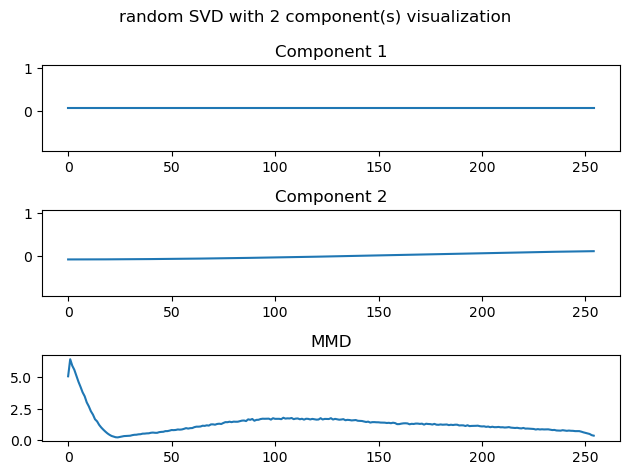

In [35]:
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar[:,0])-1
    ymax = max(codar[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

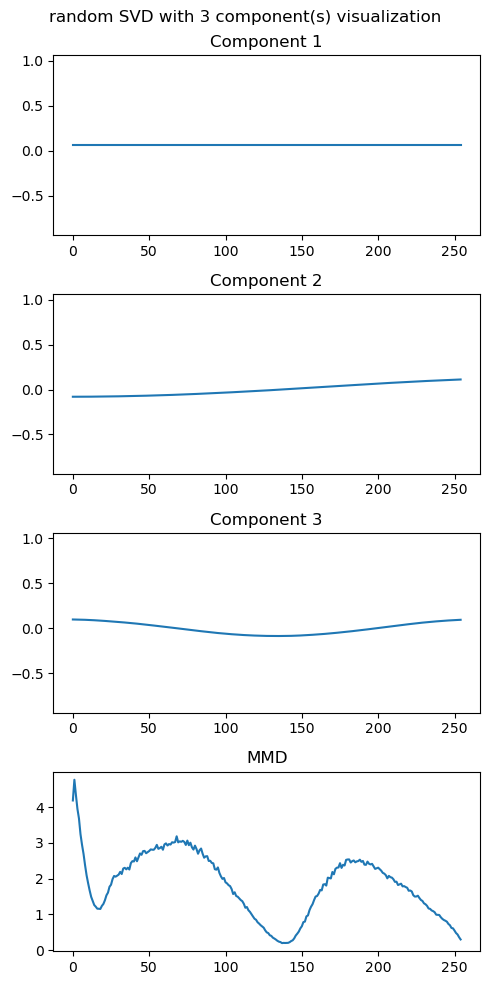

In [53]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar[:,0])-1
    ymax = max(codar[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

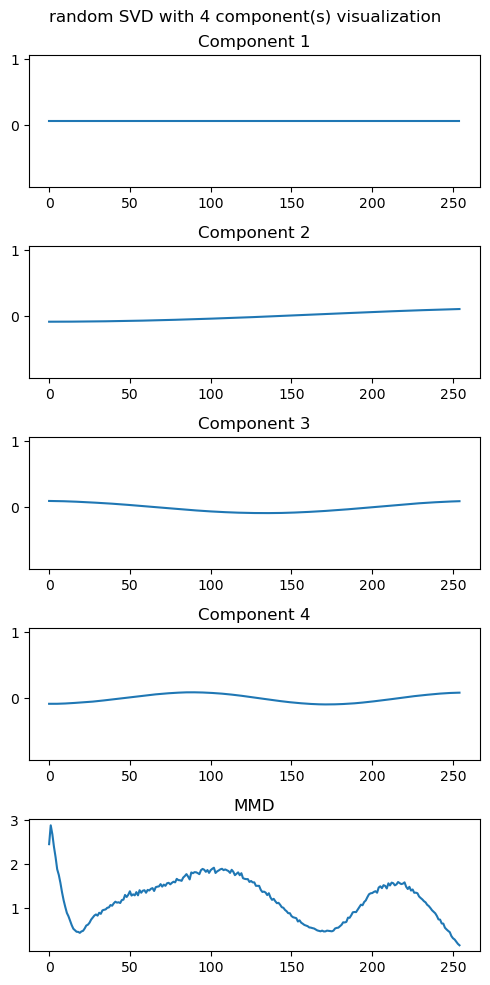

In [45]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar[:,0])-1
    ymax = max(codar[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

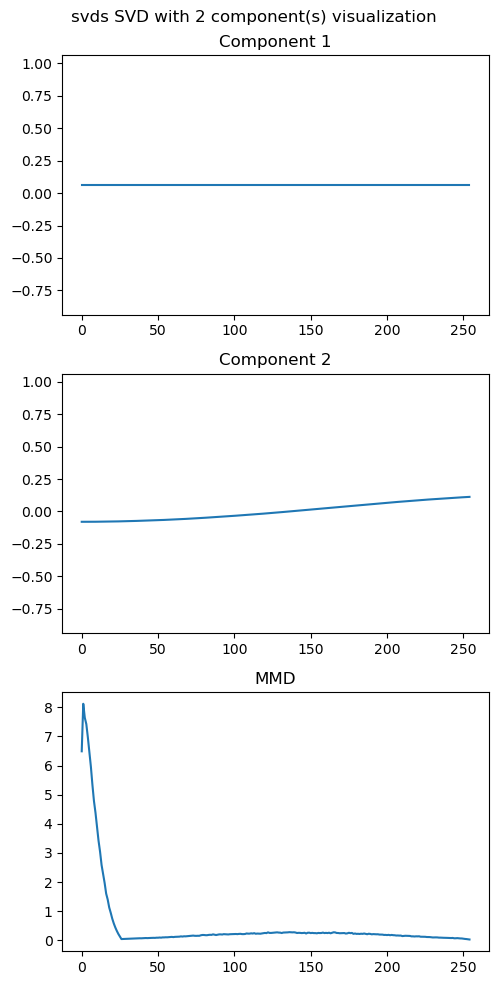

In [58]:
plt.figure(figsize=(5,10))
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar[:,0])-1
    ymax = max(codar[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()

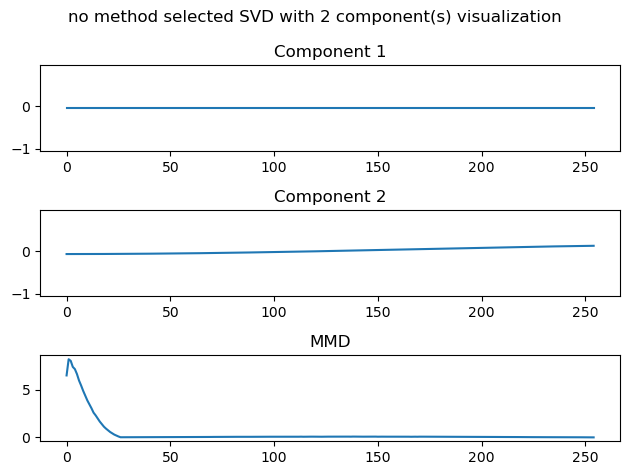

In [64]:
for i in range(components):
    plt.subplot(components+1,1,i+1)
    plt.plot(codar[:,i])
    plt.title(f'Component {i+1}')
    ymin = min(codar[:,0])-1
    ymax = max(codar[:,0])+1
    plt.ylim([ymin, ymax])
    plt.subplot(components+1, 1, components+1)

plt.plot(preds_codar)
plt.title('MMD')
plt.suptitle(f'{svd_method} SVD with {components} component(s) visualization')
plt.tight_layout()
plt.show()